In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller,acf,pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

### TASK 1

In [2]:
train_df = pd.read_csv("DS3_C1_S3_DailyDelhiClimateTrain_Data_Practice.csv",index_col="date",parse_dates=True)
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
train_df.shape

(1462, 4)

In [4]:
train_data = train_df['meantemp']
train_data.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64

In [5]:
type(train_data)

pandas.core.series.Series

In [6]:
test_df = pd.read_csv("DS3_C1_S3_DailyDelhiClimateTest_Data_Practice.csv",index_col="date",parse_dates=True)
test_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [7]:
test_df.shape

(114, 4)

In [8]:
test_data = test_df['meantemp']
test_data.head()

date
2017-01-01    15.913043
2017-01-02    18.500000
2017-01-03    17.111111
2017-01-04    18.700000
2017-01-05    18.388889
Name: meantemp, dtype: float64

In [9]:
type(test_data)

pandas.core.series.Series

In [10]:
lags = 30
moving_avg = train_df.rolling(window = lags).mean()
df_ts = pd.DataFrame({'actual':train_df['meantemp'], 'moving_average':moving_avg['meantemp']})
print(df_ts)

               actual  moving_average
date                                 
2013-01-01  10.000000             NaN
2013-01-02   7.400000             NaN
2013-01-03   7.166667             NaN
2013-01-04   8.666667             NaN
2013-01-05   6.000000             NaN
...               ...             ...
2016-12-28  17.217391       18.164807
2016-12-29  15.238095       17.952373
2016-12-30  14.095238       17.759896
2016-12-31  15.052632       17.603317
2017-01-01  10.000000       17.296372

[1462 rows x 2 columns]


In [11]:
df_ts.actual.head(lags).mean()

11.937261904761904

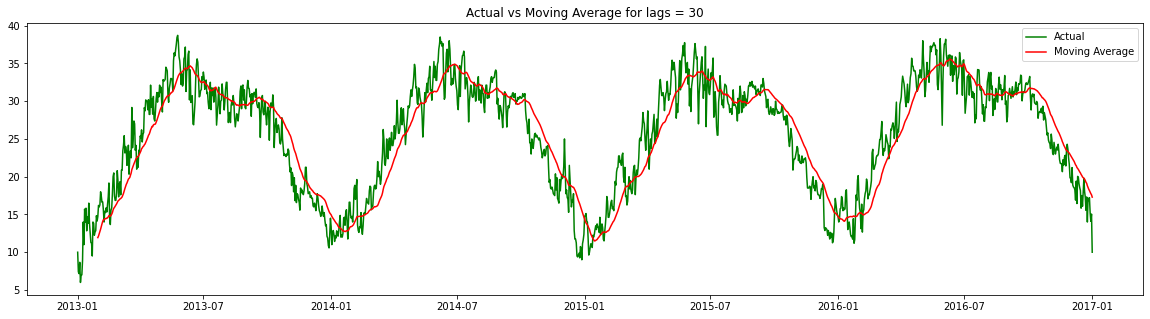

In [12]:
# plot the actual and moving average for comparison

fig,ax = plt.subplots(figsize = (20,5))
plt.plot(df_ts.actual, color='green',label = 'Actual')
plt.plot(df_ts.moving_average, color='red', label = 'Moving Average')
plt.title('Actual vs Moving Average for lags = ' + str(lags))
plt.legend()
plt.show()

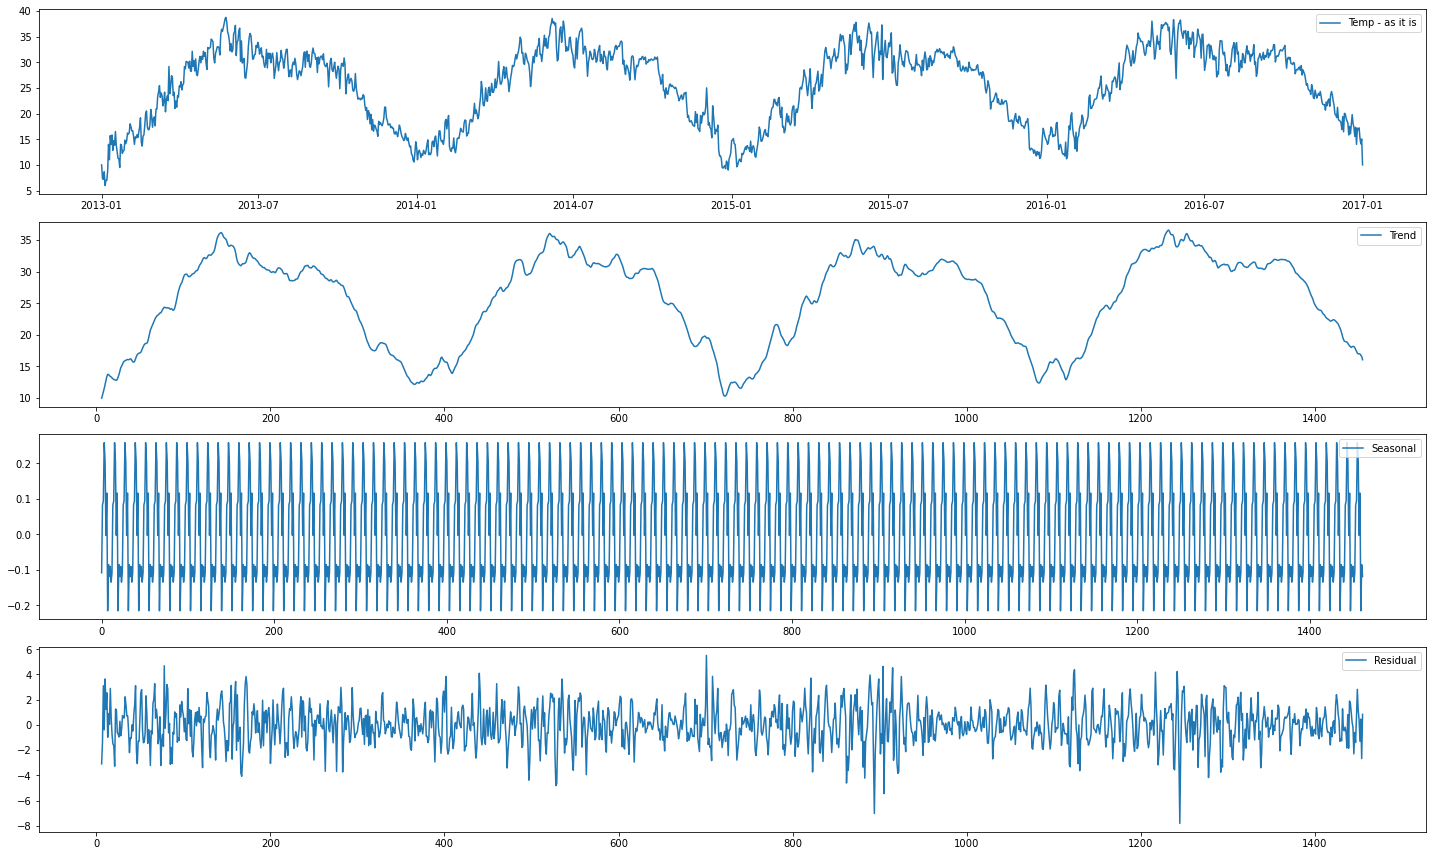

In [13]:
# different components of the Time series data

decomposition = seasonal_decompose(np.asarray(train_df.meantemp), freq = 12) #freq is 12, as there are 12 months in a year.
d_trend = decomposition.trend
d_seasonal = decomposition.seasonal
d_residual = decomposition.resid

# plotting all the 4 graphs
fig,ax = plt.subplots(4,1,figsize = (20,12))

plt.subplot(411)
plt.plot(train_df.meantemp, label = 'Temp - as it is')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(d_trend,label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(d_seasonal,label = 'Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(d_residual,label = 'Residual')
plt.legend(loc = 'best')

plt.tight_layout()

In [14]:
# Simple Exponent - when there is no trend/seasonality
def simplesmoothing(data,alpha):
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha,optimized=False)
    pdct = model.fittedvalues
    df = pd.DataFrame({'actual':data, 'forecast':pdct})
    return(model,df)

In [15]:
# create forecast for different values of alpha

# dictionary to store the forecast for each alpha
d_simple_exp = {}
alphas = [0, 0.2, 0.6, 0.8]

for a in alphas:
    model, df = simplesmoothing(train_data,a)
    d_simple_exp[a] = df.forecast

C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


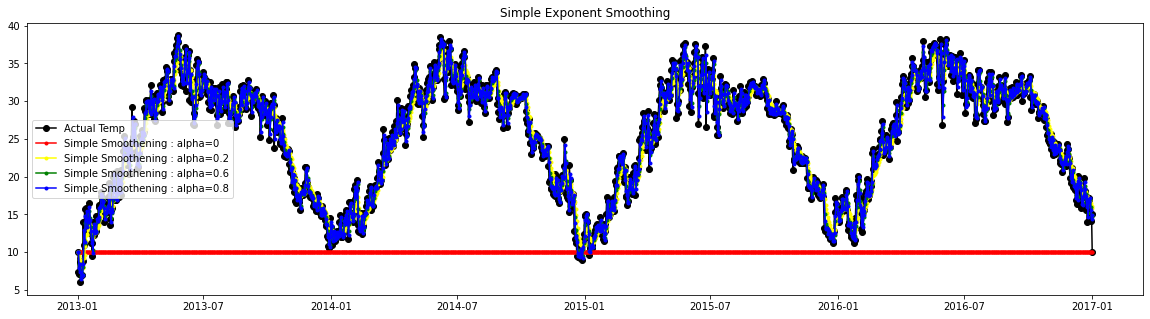

In [16]:
colors = ['red','yellow','green','blue']

# plot the actual and forecast data
fig,ax = plt.subplots(1,1,figsize=(20, 5))
plt.plot(train_data, marker='o', color='black',label='Actual Temp')

for i in range(len(alphas)):
    plt.plot(d_simple_exp[alphas[i]],marker='.',color=colors[i],label='Simple Smoothening : alpha=' + str(alphas[i]))

plt.title('Simple Exponent Smoothing')
plt.legend()
plt.show()

In [17]:
# Double Exponent - when there is a trend, no seasonality (Holts' method) 
# parameters: alpha, beta

model = ExponentialSmoothing(train_data,trend='additive').fit(smoothing_level=0.2, smoothing_slope=0.5)

# forecast with double exponent smoothing
f_dexp = model.fittedvalues
print(f_dexp)

date
2013-01-01     4.787500
2013-01-02     6.698441
2013-01-03     7.777350
2013-01-04     8.532743
2013-01-05     9.450449
                ...    
2016-12-28    15.641779
2016-12-29    15.857609
2016-12-30    15.572463
2016-12-31    14.968052
2017-01-01    14.684460
Length: 1462, dtype: float64


C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'Double Exponent Smoothing')

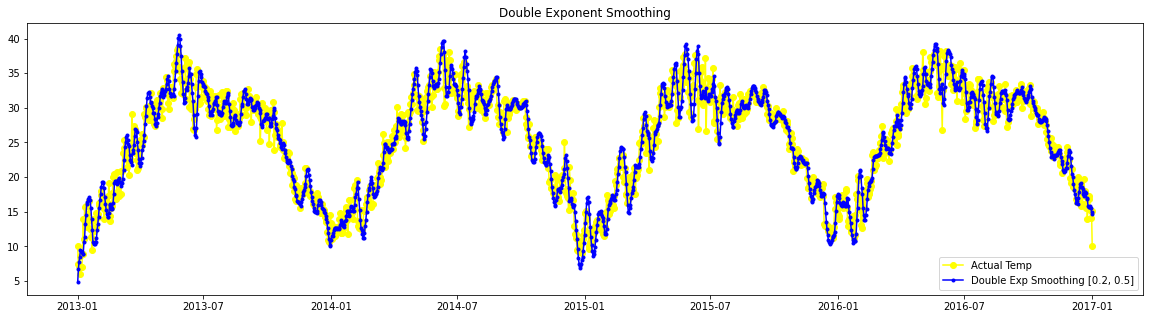

In [18]:
# plot the actual and smooth data
fig,ax = plt.subplots(1,1,figsize=(20, 5))
plt.plot(train_data,marker='o',color='yellow',label='Actual Temp')
plt.plot(f_dexp, marker='.',color='blue',label='Double Exp Smoothing [0.2, 0.5]')
plt.legend()
plt.title('Double Exponent Smoothing')

Text(0.5, 1.0, 'Triple Exponent Smoothing')

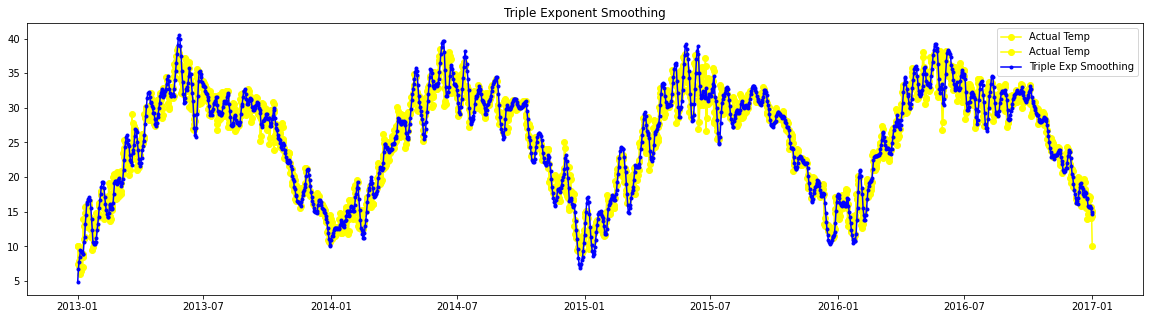

In [19]:
# plot the actual and triple smoothing values
fig,ax = plt.subplots(1,1,figsize=(20, 5))
plt.plot(df, marker='o',color='yellow',label='Actual Temp')
plt.plot(model.fittedvalues,marker='.',color='blue',label='Triple Exp Smoothing')
plt.legend()
plt.title('Triple Exponent Smoothing')

### TASK 2

In [20]:
# dickey-fuller test for stationarity
def checkStationarity(train_data):
    pvalue = adfuller(train_data)[1]
    '''
    output:-> 
    1) test statistic, 
    2) p-value, 
    3) number of lags, 
    4) total observations
    
    dfoutput = pd.Series(result[0:4],index=['tstat','pvalue','lags','obs'])
    pvalue = dfoutput['pvalue']
    '''
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [21]:
# check the data for stationarity
ret=checkStationarity(train_data); ret

'p-value=0.27741213723016156. Data is not stationary'

<AxesSubplot:xlabel='date'>

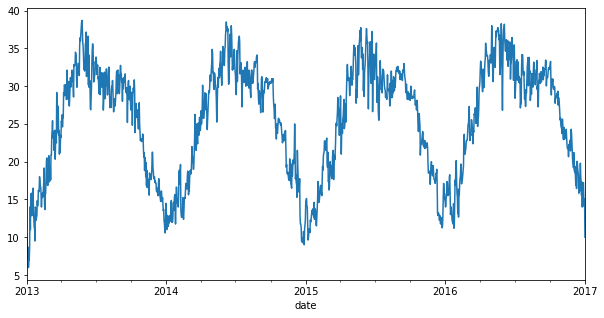

In [22]:
# the plot shows stationarity
train_data.plot(figsize=(10, 5))

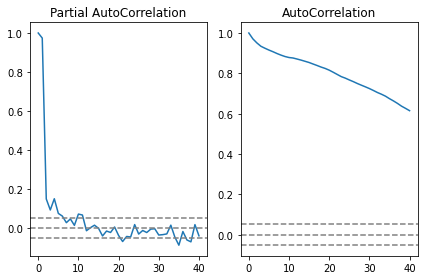

In [23]:
# p -> PACF (partial autocorrelation graph)
# q -> ACF (auto correlation graph)
# d -> differential level (from top)

# since, lags cannot be determined at the beginning, set a random number initially
lag_acf = acf(train_data, nlags=40)
lag_pacf = pacf(train_data, nlags=40, method='ols')

# plot PACF (p)
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.title("Partial AutoCorrelation")

# plot ACF (q)
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.title("AutoCorrelation")

plt.tight_layout()

In [24]:
mystock = train_df[['meantemp']]
mystock.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [25]:
# Data is not stationary
# difference the data by 1 (default)
diff_mystock = mystock - mystock.shift()
print(diff_mystock)

            meantemp
date                
2013-01-01       NaN
2013-01-02 -2.600000
2013-01-03 -0.233333
2013-01-04  1.500000
2013-01-05 -2.666667
...              ...
2016-12-28  0.367391
2016-12-29 -1.979296
2016-12-30 -1.142857
2016-12-31  0.957393
2017-01-01 -5.052632

[1462 rows x 1 columns]


In [26]:
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff_mystock))
diff_mystock.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff_mystock))
print(diff_mystock)

Before removing Nulls,total records =  1462
After removing Nulls, total records =  1461
            meantemp
date                
2013-01-02 -2.600000
2013-01-03 -0.233333
2013-01-04  1.500000
2013-01-05 -2.666667
2013-01-06  1.000000
...              ...
2016-12-28  0.367391
2016-12-29 -1.979296
2016-12-30 -1.142857
2016-12-31  0.957393
2017-01-01 -5.052632

[1461 rows x 1 columns]


In [27]:
# check if the differenced data is stationary
checkStationarity(diff_mystock)

'p-value=2.764863137594288e-29. Data is stationary'

<AxesSubplot:xlabel='date'>

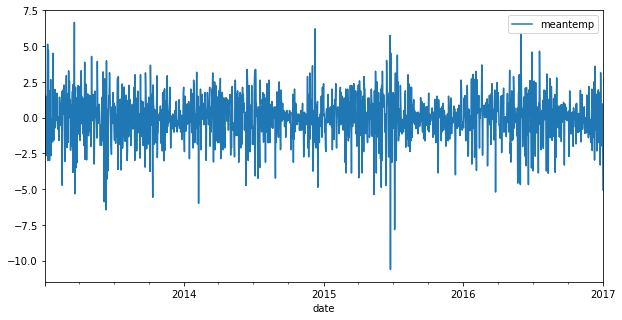

In [28]:
diff_mystock.plot(figsize=(10, 5))

Text(0.5, 1.0, 'Actual vs Differenced data')

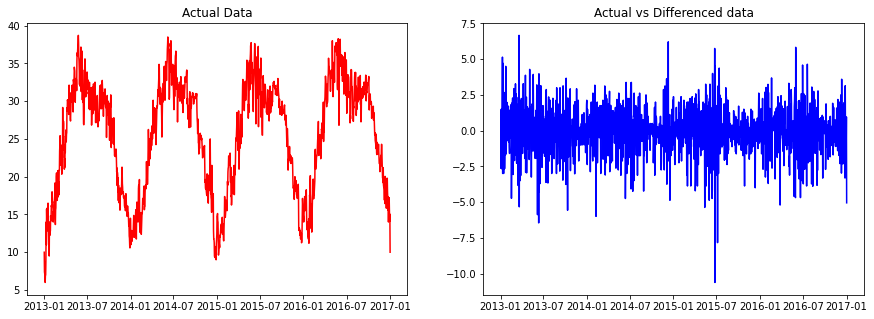

In [29]:
# plot the Actual data and Differenced data
fig,ax = plt.subplots(1,1,figsize=(15, 5))

plt.subplot(121)
plt.plot(mystock,color='red')
plt.title('Actual Data')

plt.subplot(122)
plt.plot(diff_mystock,color='blue')
plt.title('Differenced Data')

plt.title("Actual vs Differenced data")

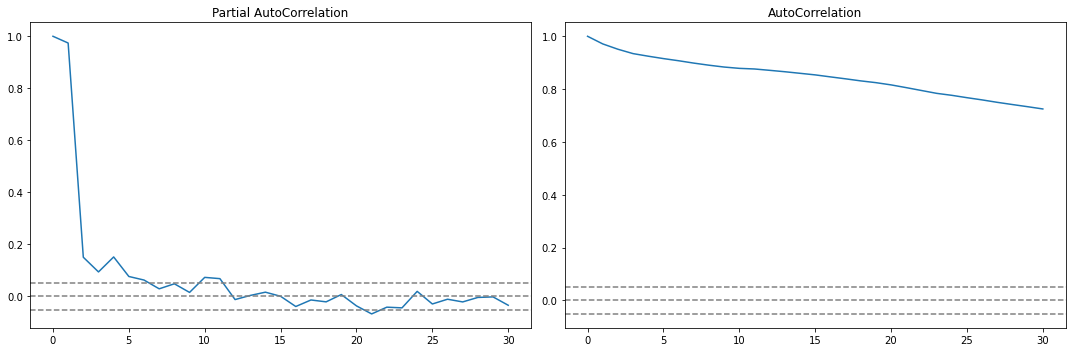

In [30]:
# p -> PACF (partial autocorrelation graph)
# q -> ACF (auto correlation graph)
# d -> differential level (from top)

# since, lags cannot be determined at the beginning, set a random number initially
lag_acf = acf(train_data, nlags=30)
lag_pacf = pacf(train_data, nlags=30, method='ols')

fig,ax = plt.subplots(1,1,figsize=(15, 5))

# plot PACF (p)
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.title("Partial AutoCorrelation")

# plot ACF (q)
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color="gray")
plt.axhline(y=-1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.axhline(y=1.96/np.sqrt(len(train_data)),linestyle='--',color="gray")
plt.title("AutoCorrelation")

plt.tight_layout()

### TASK 3

In [31]:
# Building ARMA model = 1

p = 1; q = 1
model_1 = ARIMA(train_data, order = (p, 0, q)).fit()
print('MODEL = 1', model_1.summary())

C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


MODEL = 1                                SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2797.106
Date:                Tue, 26 Apr 2022   AIC                           5602.211
Time:                        17:58:12   BIC                           5623.361
Sample:                    01-01-2013   HQIC                          5610.101
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.1435      2.192     11.013      0.000      19.847      28.440
ar.L1          0.9862      0.004    227.285      0.000       0.978       0.995
ma.L1         -0.2057      0.021     -9.82

In [32]:
# Building ARMA model = 2

p = 2; q = 2
model_2 = ARIMA(train_data, order = (p, 0, q)).fit()
print('MODEL = 2', model_2.summary())

C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


MODEL = 2                                SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2770.394
Date:                Tue, 26 Apr 2022   AIC                           5552.789
Time:                        17:58:13   BIC                           5584.514
Sample:                    01-01-2013   HQIC                          5564.623
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.4266      4.057      5.281      0.000      13.474      29.379
ar.L1          1.5361      0.088     17.391      0.000       1.363       1.709
ar.L2         -0.5380      0.088     -6.13

In [33]:
# Building ARMA model = 3

p = 3; q = 3
model_3 = ARIMA(train_data, order = (p, 0, q)).fit()
print('MODEL = 3', model_3.summary())

C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PAL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


MODEL = 3                                SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -2767.337
Date:                Tue, 26 Apr 2022   AIC                           5550.674
Time:                        17:58:17   BIC                           5592.975
Sample:                    01-01-2013   HQIC                          5566.453
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8291      3.729      5.854      0.000      14.520      29.138
ar.L1          0.9298      0.254      3.665      0.000       0.433       1.427
ar.L2          0.2682      0.416      0.64

In [34]:
# predictions
predictions = model_2.predict(0, len(test_data)-1)
predictions

2013-01-01    21.426615
2013-01-02    10.217816
2013-01-03     8.028663
2013-01-04     7.751403
2013-01-05     8.837041
                ...    
2013-04-20    28.476771
2013-04-21    30.267100
2013-04-22    27.997615
2013-04-23    27.736695
2013-04-24    28.620879
Freq: D, Name: predicted_mean, Length: 114, dtype: float64

In [35]:
# actual vs predicted values

actual = []; pred = []

for i in range(len(predictions)):
    actual.append(test_data[i])
    pred.append(predictions[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)

        actual  predicted        err
0    15.913043  21.426615  -5.513572
1    18.500000  10.217816   8.282184
2    17.111111   8.028663   9.082448
3    18.700000   7.751403  10.948597
4    18.388889   8.837041   9.551848
..         ...        ...        ...
109  34.500000  28.476771   6.023229
110  34.250000  30.267100   3.982900
111  32.900000  27.997615   4.902385
112  32.875000  27.736695   5.138305
113  32.000000  28.620879   3.379121

[114 rows x 3 columns]


        actual  predicted        err
0    15.913043  21.426615  -5.513572
1    18.500000  10.217816   8.282184
2    17.111111   8.028663   9.082448
3    18.700000   7.751403  10.948597
4    18.388889   8.837041   9.551848
..         ...        ...        ...
109  34.500000  28.476771   6.023229
110  34.250000  30.267100   3.982900
111  32.900000  27.997615   4.902385
112  32.875000  27.736695   5.138305
113  32.000000  28.620879   3.379121

[114 rows x 3 columns]


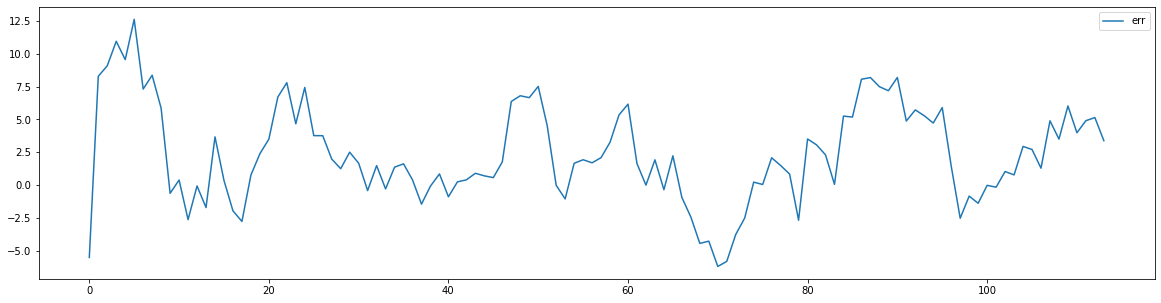

In [36]:
# errors
print(df_res)
df_res.err.plot(figsize=(20, 5),legend=True);

In [37]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(model_1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [38]:
# MSE
msg = 'ARMA Model. Order=(' + str(p) + ',' + str(q) + ')'
mse_1 = mean_squared_error(df_res.actual, df_res.predicted)
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse_1,np.sqrt(mse_1)))

ARMA Model. Order=(3,3)
	MSE = 19.105659939117597
	RMSE = 4.371002166450801


Text(0.5, 1.0, 'ARMA Model. Order=(3,3)')

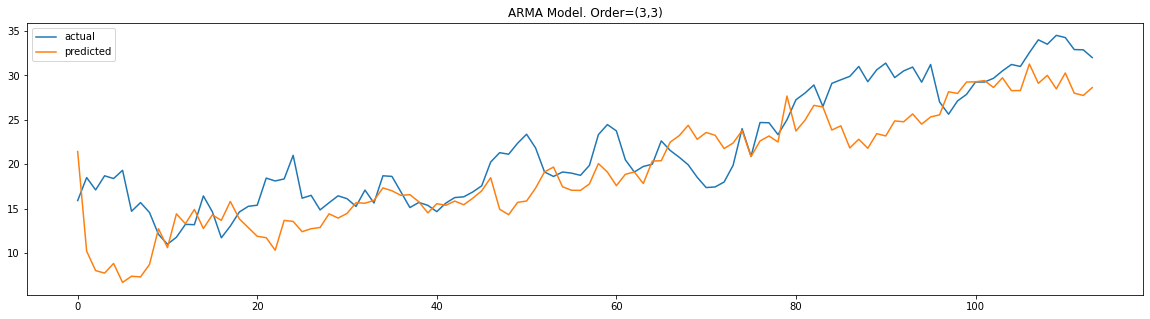

In [39]:
# plotting actual vs predicted values

df_res.actual.plot(figsize=(20, 5),legend=True)
df_res.predicted.plot(legend=True)
plt.title(msg)